# **Clustering Mall Customers: K-Means Approach**
   by *Sadiq Balogun*

# **Objective**
The aim of this project is to segment the customers of a mall into groups, so that the business can make informed decisions based on each groups.

### Import Necessary Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pickle
import joblib


import warnings
warnings.filterwarnings('ignore')

palette = {'#05668D', '#02C39A', '#F0F3BD', '#E63B2E', '#3D0814', '#FCAB10'}

### Load Dataset

In [2]:
df = pd.read_csv('Mall_Customers.csv')

### Preview of the dataset

In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Statistical summary of the dataset

In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Observation:<br>
In our dataset, we have 200 customers. The average age of these customers is 38.8 years, with the youngest individual being 18 years old and the oldest one being 70 years old. Additionally, the customers' incomes vary from a minimum of 15,000 USD to a maximum of 137,000 USD. On average, the income for all customers in the dataset is 60,000 USD.

### Data Cleaning: Checking for inconsistencies in the dataset

### Checking for null values and data type

In [5]:
print(df.isnull().sum())
print('-------')
print(df.dtypes)

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
-------
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


### Checking for duplicates

In [6]:
print(df.duplicated().sum())

0


The gender column is mis-spelled, so we are going to correct that and also rename other columns

In [7]:
column_mapping = {'Genre': 'Gender', 'Annual Income (k$)': 'Annual_income', 'Spending Score (1-100)':'Spending_score'}
df.rename(columns=column_mapping, inplace=True)
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Exploratory Data Analysis

### Gender distribution

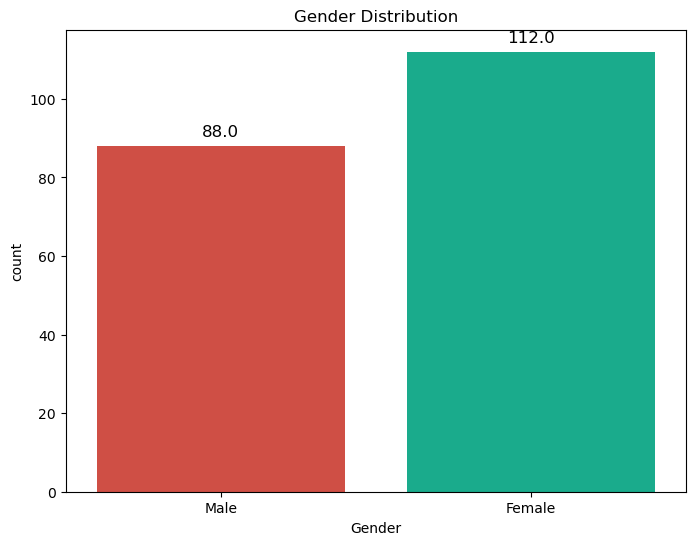

In [8]:
# Create the countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df, palette=palette)

# Add count labels at the top of each column
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.title('Gender Distribution')
plt.show()

### Continous variables distribution plot

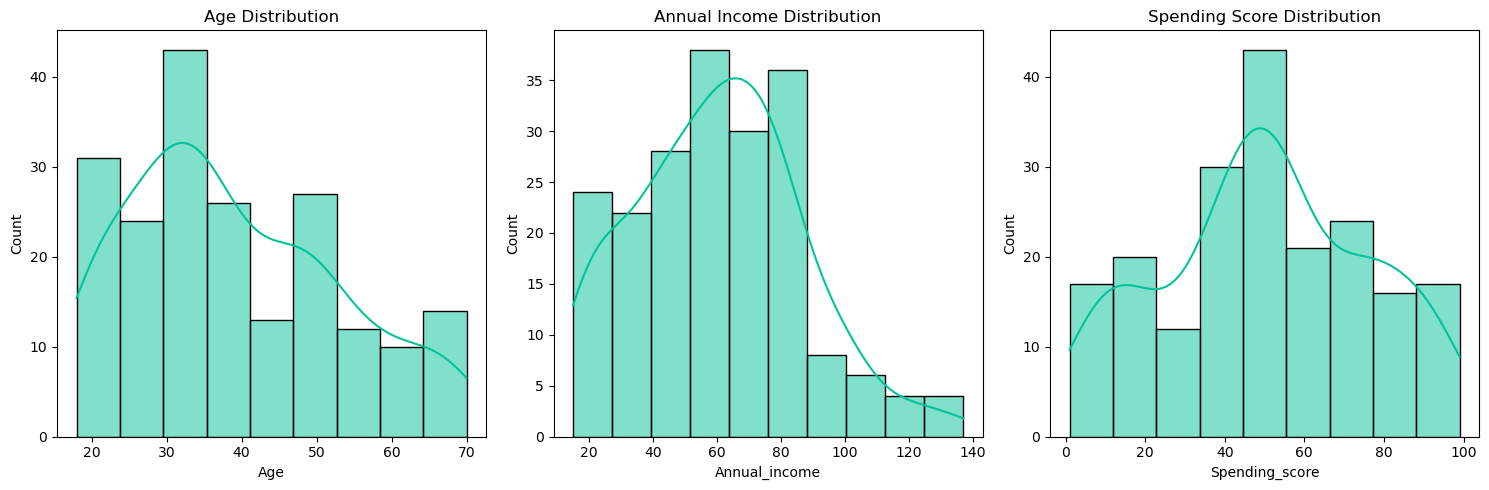

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create displots for each column
sns.histplot(df['Age'], kde=True, ax=axes[0], color='#02C39A')
axes[0].set_title('Age Distribution')

sns.histplot(df['Annual_income'], kde=True, ax=axes[1], color='#02C39A')
axes[1].set_title('Annual Income Distribution')

sns.histplot(df['Spending_score'], kde=True, ax=axes[2], color='#02C39A')
axes[2].set_title('Spending Score Distribution')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Multi-variate plots

### Correlation plot between Age and Income

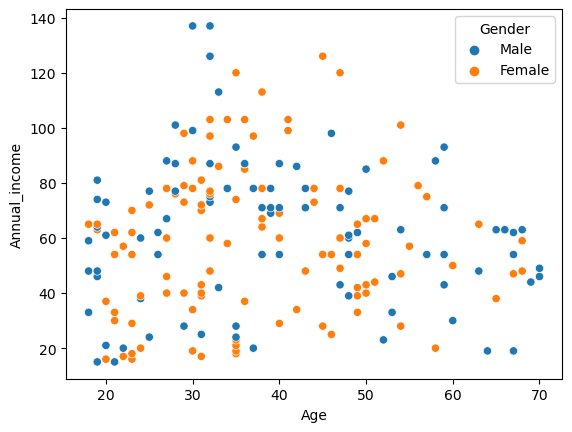

In [10]:
sns.scatterplot(df, x='Age', y='Annual_income', hue='Gender')
plt.show()

### Correlation plot between Age and Spending score

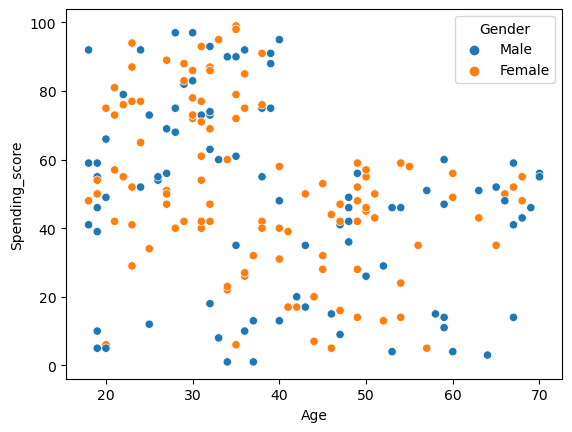

In [11]:
sns.scatterplot(df, x='Age', y='Spending_score', hue='Gender')
plt.show()

### Correlation plot between Income and Spending score

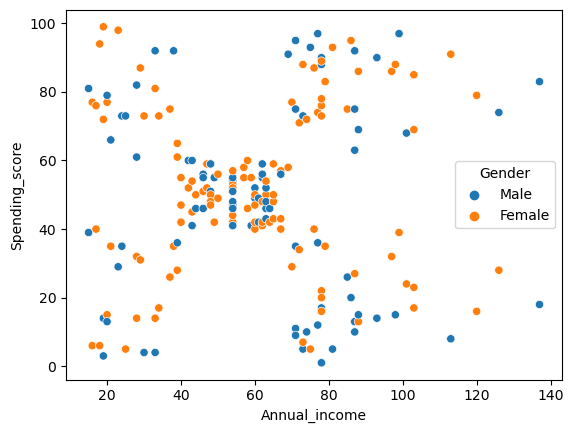

In [12]:
sns.scatterplot(df, x='Annual_income', y='Spending_score', hue='Gender')
plt.show()

### Observations <br>
* Most customers in the dataset are around 30-35 years old.
* Most of the customers' annual income range between 50k - 90k USD
* Customers that are older than 40 years having spending scores less than 60
* Not all customers with high income have high spending score, and not all customers with low income have low spending score.

### Feature Selection
We will be using Age, Income and Spending score as features that will determine the clusters.

In [13]:
# Peforming the clustering based on three features: Age, income, and spending score
X = df[['Age', 'Annual_income', 'Spending_score']]

### Correlation Plot

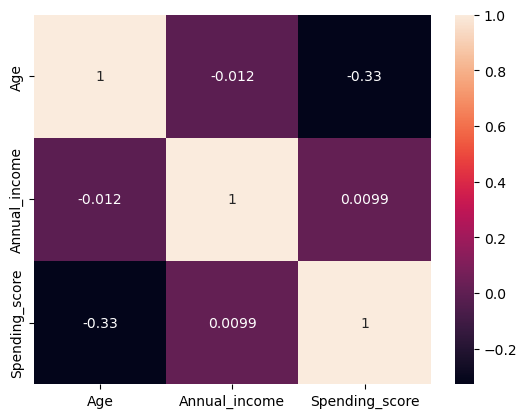

In [14]:
sns.heatmap(X.corr(), annot=True)
plt.show()

### Scaling the features with Standard Scaler

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Determining the Optimal K value using Elbow Method and Silhouette Method
The optimal k value will tell us the number of clusters that's best for this dataset.

### Elbow method

In [16]:
SSE = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    SSE.append(kmeans.inertia_)

### Plot the elbow method graph

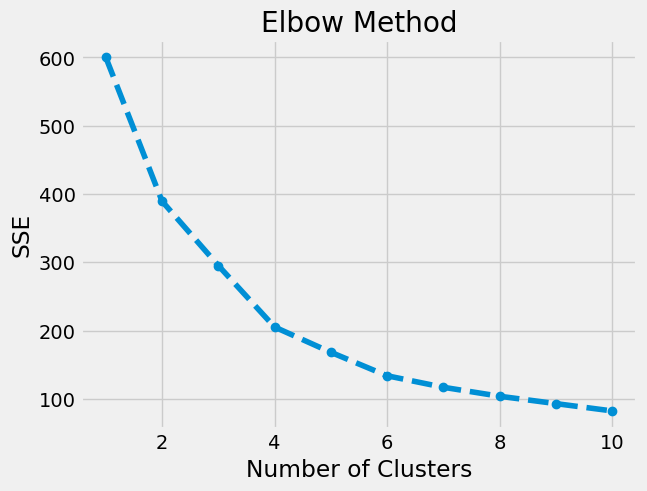

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

### Silhouette Method

In [18]:
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

### Plot silhouette scores

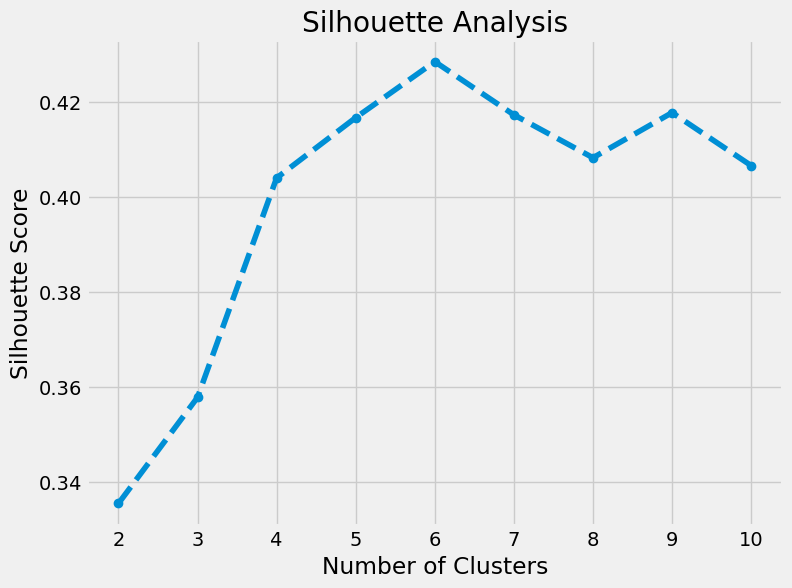

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## K-MEANS CLUSTERING 

### Using 4 Clusters

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
X['Cluster'] = kmeans.labels_

print(X.head())

   Age  Annual_income  Spending_score  Cluster
0   19             15              39        2
1   21             15              81        2
2   20             16               6        2
3   23             16              77        2
4   31             17              40        2


### Plotting the Clusters in 3D

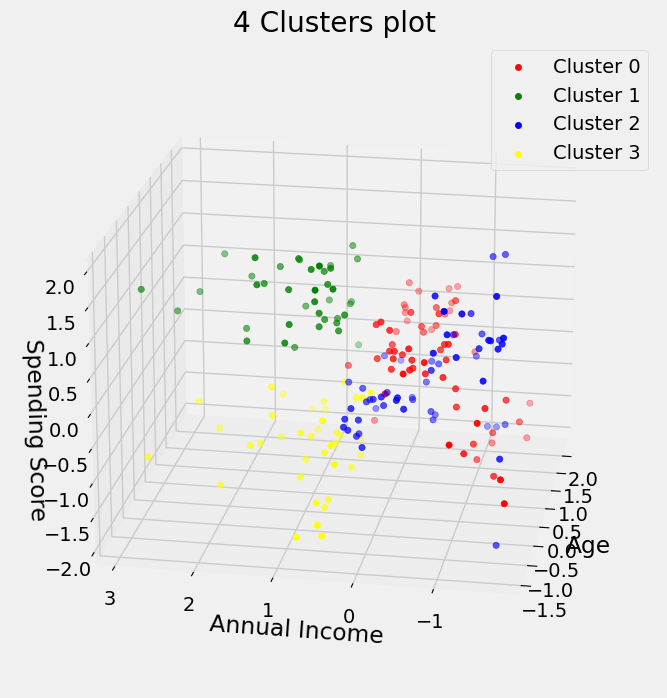

In [21]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')

# Assigning different colors to each cluster
colors = ['red', 'green', 'blue', 'yellow']
for cluster in range(4):
    ax.scatter(X_scaled[X['Cluster'] == cluster, 0],
               X_scaled[X['Cluster'] == cluster, 1],
               X_scaled[X['Cluster'] == cluster, 2],
               c=colors[cluster], label=f'Cluster {cluster}')
ax.view_init(20, 190)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.set_title('4 Clusters plot')
ax.legend()
plt.show()

### Using 6 clusters

In [22]:
k_means = KMeans(n_clusters=6, random_state=42)
k_means.fit(X_scaled)
X['Cluster'] = k_means.labels_

### Plotting the Clusters in 3D

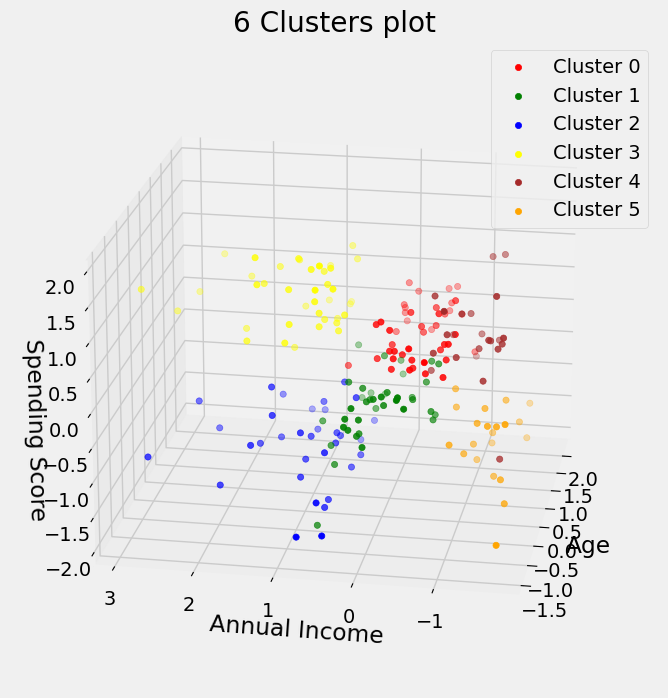

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assigning different colors to each cluster
colors = ['red', 'green', 'blue', 'yellow', 'brown', 'orange']
for cluster in range(6):
    ax.scatter(X_scaled[X['Cluster'] == cluster, 0],
               X_scaled[X['Cluster'] == cluster, 1],
               X_scaled[X['Cluster'] == cluster, 2],
               c=colors[cluster], label=f'Cluster {cluster}')
ax.view_init(20, 190)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.set_title('6 Clusters plot')
ax.legend()
plt.show()

### Observation: 
The clusters are no well differentiated from the above plots, so the next thing to do is to reduce the diemnsion of the data using Principal Component Analysis (PCA)

## Dimensionality Reduction: PCA
Reducing the dimension of the dataframe into 2D

### Perform PCA on the scaled data with 2 components

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert the PCA results to a DataFrame
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca.head()

,PC1,PC2
0,-0.615720,-1.763481
1,-1.665793,-1.820747
2,0.337862,-1.674799
3,-1.456573,-1.772430
4,-0.038465,-1.662740


## Modeling

### Using 4 clusters

In [25]:
kmeans_four = KMeans(n_clusters=4, random_state=42)
kmeans_four.fit_predict(X_pca)
df_pcs_kmeans = pd.concat([df_pca, pd.DataFrame({'Cluster':kmeans_four.labels_})], axis=1)

### Visualizing the clusters

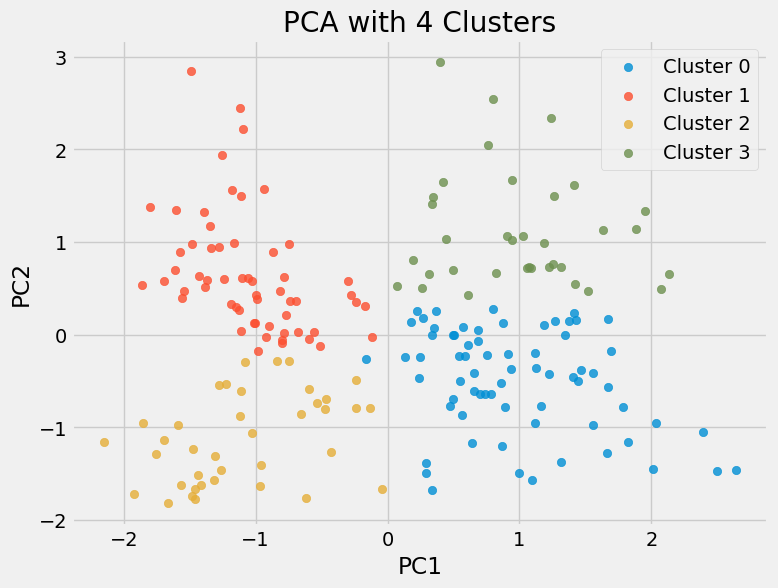

In [26]:
plt.figure(figsize=(8, 6))
for cluster in range(4):
    plt.scatter(df_pcs_kmeans[df_pcs_kmeans['Cluster'] == cluster]['PC1'],
                df_pcs_kmeans[df_pcs_kmeans['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 4 Clusters')
plt.legend()
plt.show()

### Using 6 clusters

In [27]:
kmeans_six = KMeans(n_clusters=6, random_state=42)
kmeans_six.fit_predict(X_pca)
df_pcs_kmeans = pd.concat([df_pca, pd.DataFrame({'Cluster':kmeans_six.labels_})], axis=1)

### Visualizing the clusters

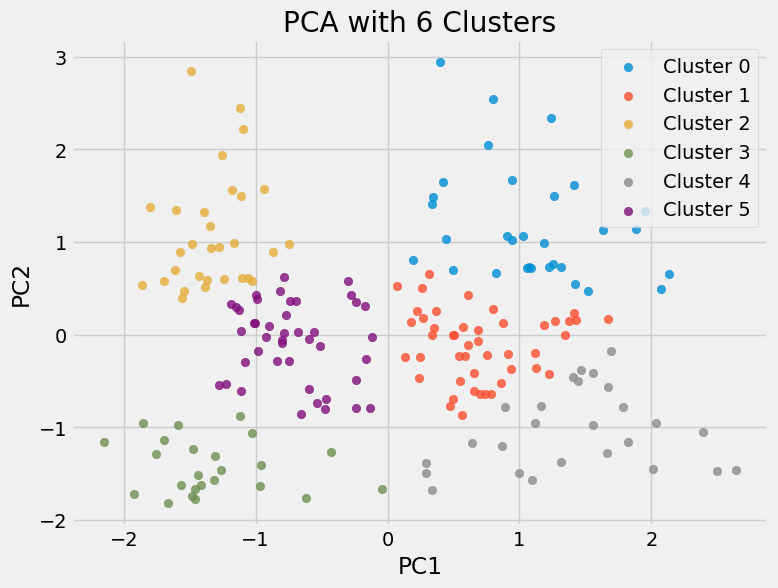

In [28]:
plt.figure(figsize=(8, 6))
for cluster in range(6):
    plt.scatter(df_pcs_kmeans[df_pcs_kmeans['Cluster'] == cluster]['PC1'],
                df_pcs_kmeans[df_pcs_kmeans['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 6 Clusters')
plt.legend()
plt.show()

### Observation

We can see that after employing PCA, the clusters can be seen more clearly.

### Creating a target column for storing the clusters in the 4-cluster model

In [29]:
cluster4_df = pd.concat([df, pd.DataFrame({'Cluster':kmeans.labels_})], axis=1)
cluster4_df

,CustomerID,Gender,Age,Annual_income,Spending_score,Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,2
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2
...,...,...,...,...,...,...
195,196,Female,35,120,79,1
196,197,Female,45,126,28,3
197,198,Male,32,126,74,1
198,199,Male,32,137,18,3


### Dropping the customer ID column

In [30]:
cluster4_df = cluster4_df.drop(['CustomerID'], axis=1)

### Visualization of the cluster distribution

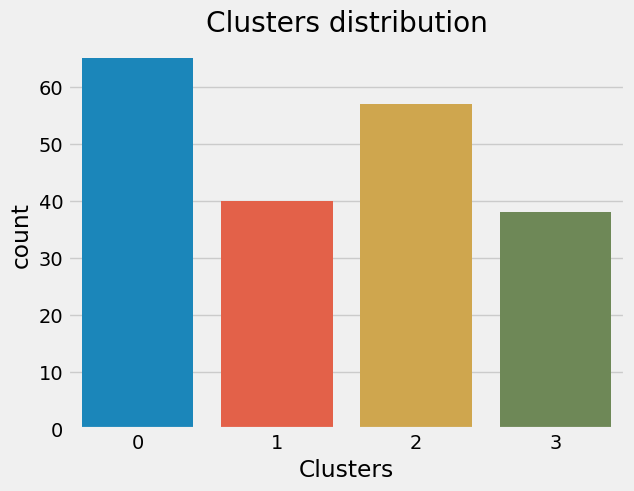

In [31]:
sns.countplot(x='Cluster', data=cluster4_df)
plt.title('Clusters distribution')
plt.xlabel('Clusters')
plt.show()

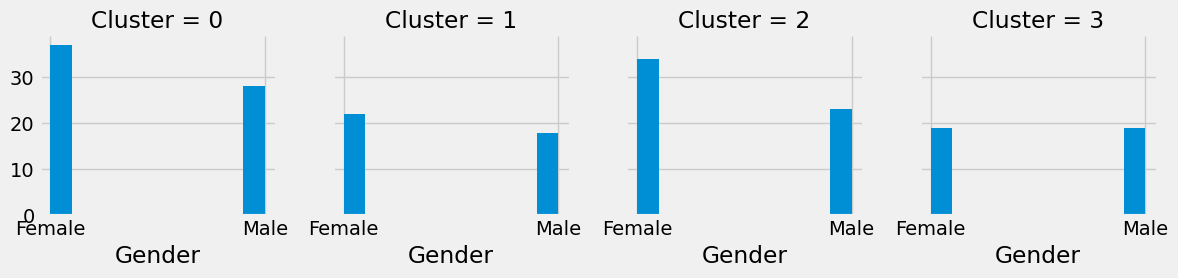

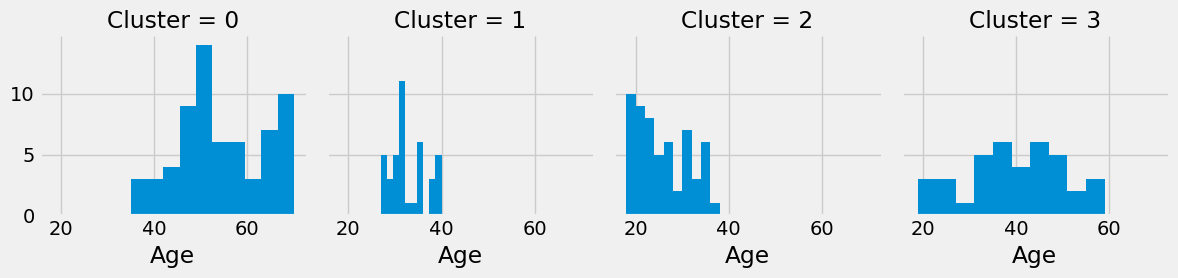

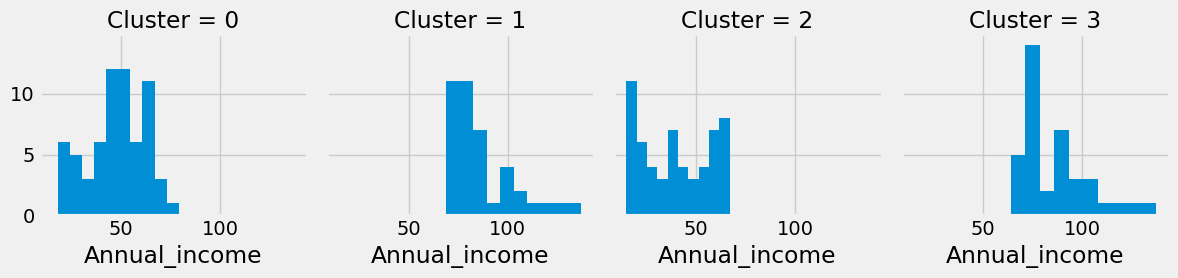

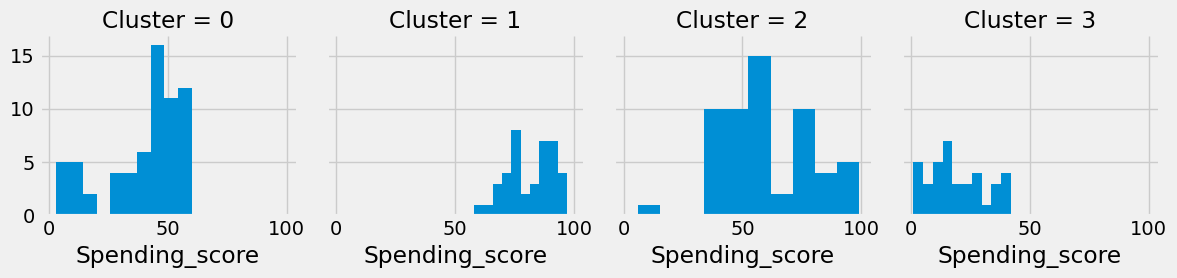

In [32]:
for c in cluster4_df.drop(['Cluster'],axis=1):
    grid= sns.FacetGrid(cluster4_df, col='Cluster')
    grid= grid.map(plt.hist, c)
plt.show()

### Calculate the mean values of the original features for each cluster

In [33]:
# Specify the columns to include in the mean calculation
columns_to_mean = ['Age', 'Annual_income', 'Spending_score']

# Calculate the mean values of the specified features for each cluster
cluster_mean = cluster4_df.groupby('Cluster')[columns_to_mean].mean()

# Display the mean values for each cluster
print(cluster_mean)


               Age  Annual_income  Spending_score
Cluster                                          
0        53.984615      47.707692       39.969231
1        32.875000      86.100000       81.525000
2        25.438596      40.000000       60.298246
3        39.368421      86.500000       19.578947


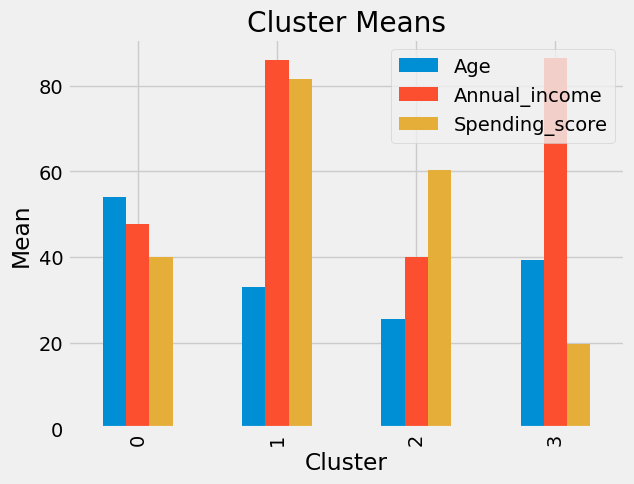

In [34]:
cluster_mean.plot.bar()
plt.title('Cluster Means')
plt.xlabel('Cluster')
plt.ylabel('Mean')
plt.show()

### Creating a target column for storing the clusters in the 6-cluster model

In [35]:
cluster_df = pd.concat([df, pd.DataFrame({'Cluster':kmeans_six.labels_})], axis=1)
cluster_df

,CustomerID,Gender,Age,Annual_income,Spending_score,Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,3
2,3,Female,20,16,6,4
3,4,Female,23,16,77,3
4,5,Female,31,17,40,3
...,...,...,...,...,...,...
195,196,Female,35,120,79,2
196,197,Female,45,126,28,0
197,198,Male,32,126,74,2
198,199,Male,32,137,18,0


### Drop the CustomerID column

In [36]:
cluster_df = cluster_df.drop(['CustomerID'], axis=1)

### Visualization of the clusters distribution

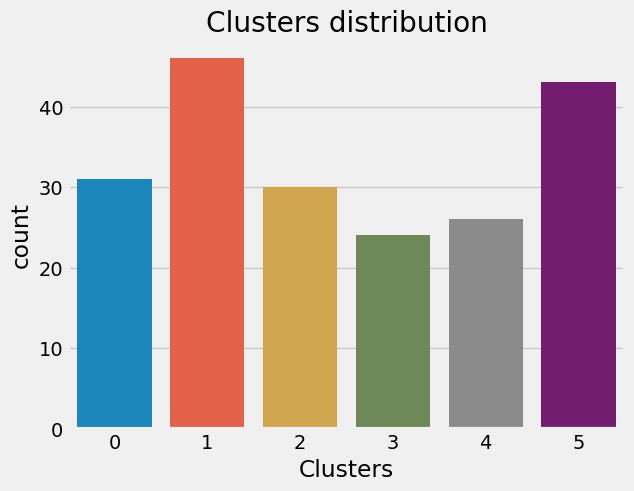

In [37]:
sns.countplot(x='Cluster', data=cluster_df)
plt.title('Clusters distribution')
plt.xlabel('Clusters')
plt.show()

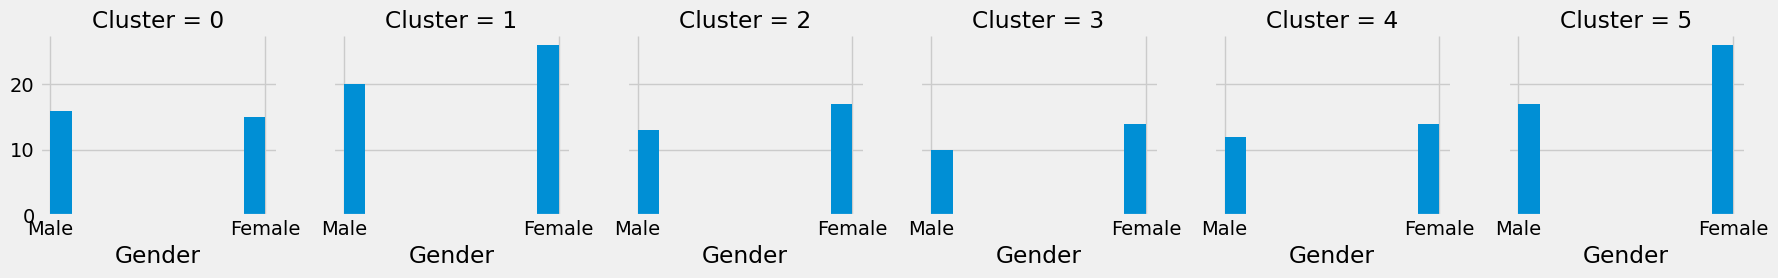

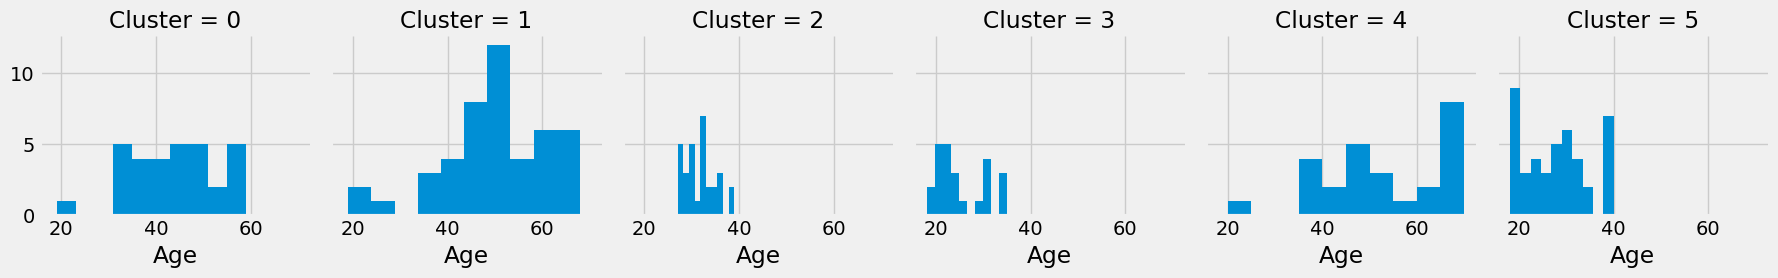

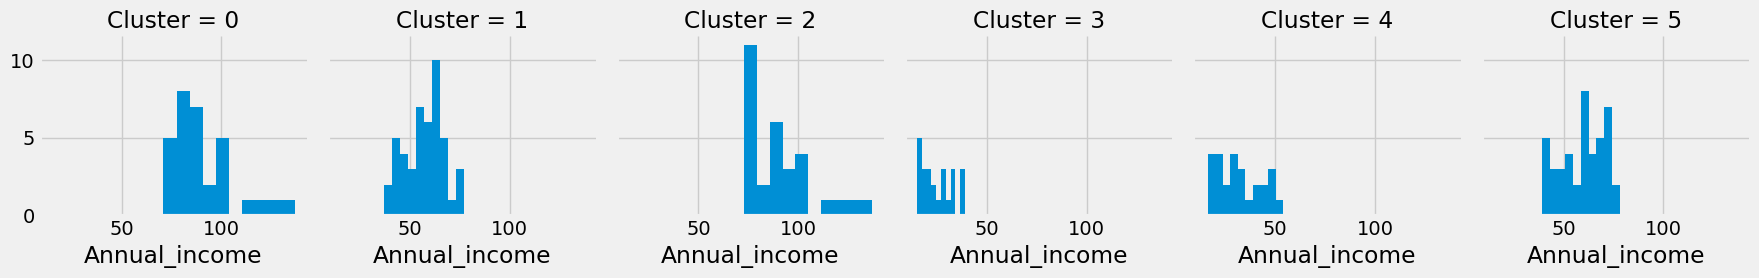

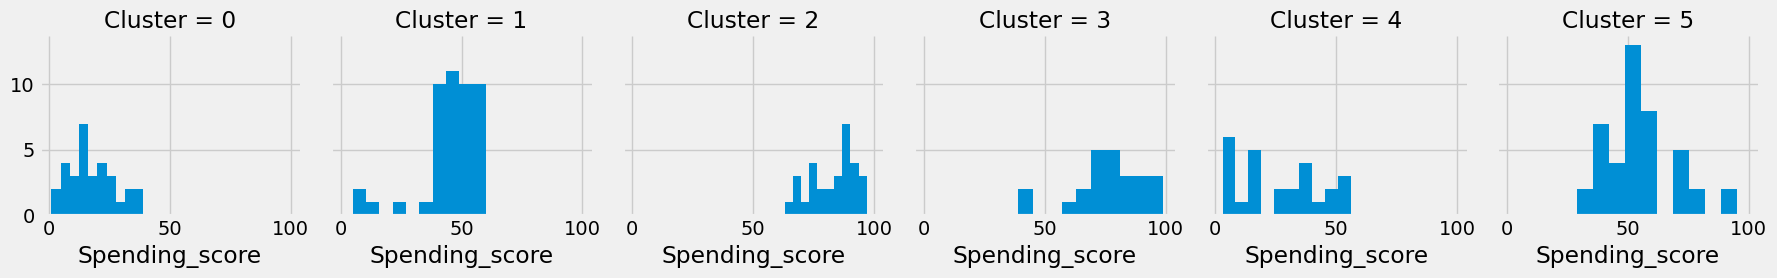

In [38]:
for c in cluster_df.drop(['Cluster'],axis=1):
    grid= sns.FacetGrid(cluster_df, col='Cluster')
    grid= grid.map(plt.hist, c)
plt.show()

### Calculate the mean values of the original features for each cluster

In [39]:
mean_columns = ['Age', 'Annual_income', 'Spending_score']

cluster_means = cluster_df.groupby('Cluster')[mean_columns].mean()

# Display the mean values for each cluster
print(cluster_means)

               Age  Annual_income  Spending_score
Cluster                                          
0        43.612903      90.096774       17.516129
1        50.043478      56.826087       45.608696
2        31.733333      90.866667       83.266667
3        25.250000      24.916667       76.041667
4        52.500000      31.692308       25.923077
5        27.744186      59.465116       55.860465


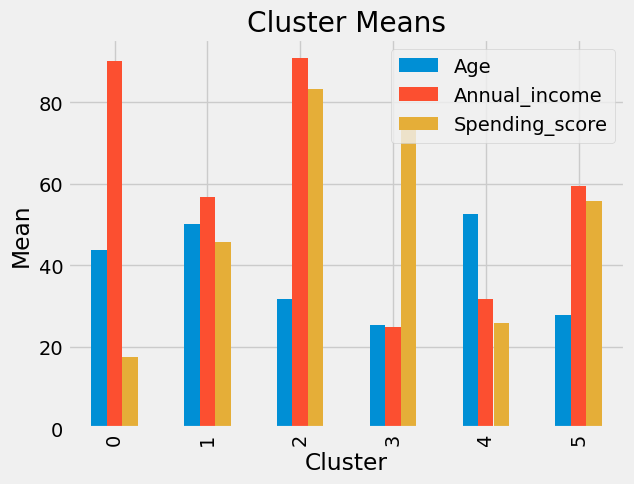

In [40]:
cluster_means.plot.bar()
plt.title('Cluster Means')
plt.xlabel('Cluster')
plt.ylabel('Mean')
plt.show()

### Observations
* Cluster 0 in the 4-cluster model and cluster 0 in the 6-cluster model are similar. They are middle aged customers with around average annual income and spending score.
* Cluster 1 in the 4-cluster model and cluster 1 in the 6-cluster model are similar. They are customers in their 30s with high average annual income and spending score.
* Cluster 2 in the 4-cluster model and cluster 3 in the 6-cluster model are similar. They are the youngest clusters with low annual income but high spending score.
* Cluster 3 in the 4-cluster model and cluster 2 in the 6-cluster model are similar. They are also middles aged customers with high annual income but very low spending score.

Given the observed similarities between clusters in both the 4-cluster and 6-cluster models, which effectively capture the major segments in the data, I have decided to proceed with building a classification model based on the 4-cluster representation. This choice is motivated by the simplicity, interpretability, and consistency across the two models, providing a clear and actionable framework for further analysis and decision-making.

### Saving the 4-cluster data as a csv file

In [41]:
cluster4_df.to_csv("Cluster_customer_data.csv")

### Encoding the Gender column for ML purpose

In [42]:
le = LabelEncoder()
cluster4_df['Gender'] = le.fit_transform(cluster4_df['Gender'])

### Data Split - 70:30 ratio

In [43]:
# Labels
y = cluster4_df[['Cluster']]   

# Features
X = cluster4_df.drop(['Cluster'], axis=1)   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

### Structure of the Train and Test data

In [44]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print("y_train: \n",y_train.value_counts())
print("y_test: \n",y_test.value_counts())

X_train:  (140, 4)
X_test:  (60, 4)
y_train: 
 Cluster
0          43
2          39
3          30
1          28
Name: count, dtype: int64
y_test: 
 Cluster
0          22
2          18
1          12
3           8
Name: count, dtype: int64


### Training & Testing 3 Multi-class Algorithms: Random Forest, Decision Tree & Logistics Regression

### Random Forest

In [45]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("\nModel Evaluation on Test Set:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Cross-Validation Scores: [0.92857143 1.         0.92857143 1.         0.92857143]
Mean CV Accuracy: 0.9571428571428571

Model Evaluation on Test Set:
Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       1.00      1.00      1.00        12
           2       0.94      0.94      0.94        18
           3       1.00      1.00      1.00         8

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



### Decision Tree 

In [46]:
# Create a Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(random_state=69)

# Perform cross-validation
cv_scores = cross_val_score(tree_classifier, X_train, y_train, cv=5)

# Train the model on the training data
tree_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = tree_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("\nModel Evaluation on Test Set:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Cross-Validation Scores: [0.96428571 0.96428571 0.89285714 0.96428571 0.92857143]
Mean CV Accuracy: 0.9428571428571428

Model Evaluation on Test Set:
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       1.00      1.00      1.00        12
           2       0.94      0.94      0.94        18
           3       0.88      0.88      0.88         8

    accuracy                           0.95        60
   macro avg       0.94      0.94      0.94        60
weighted avg       0.95      0.95      0.95        60



### Logistics Regression 

In [47]:
# Create a Logistic Regression Classifier
logistic_classifier = LogisticRegression(max_iter=1000, random_state=69)

# Perform cross-validation
cv_scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5)

# Train the model on the training data
logistic_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = logistic_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("\nModel Evaluation on Test Set:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Cross-Validation Scores: [0.96428571 1.         1.         0.96428571 1.        ]
Mean CV Accuracy: 0.9857142857142858

Model Evaluation on Test Set:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         8

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



### Saving the 4-Cluster model

In [48]:
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans_four, file)

### Saving the Random Forest Model

In [50]:
with open('randomforest_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

In [55]:
joblib.dump(rf_classifier, 'randomforest_model.joblib')

['randomforest_model.joblib']

#### Next step is to deploy the model and use it for prediction